**Версии библиотек:**

- pandas 2.1.4
- numpy 1.26.4
- statsmodels 0.14.0
- seaborn 0.13.2
- matplotlib 3.8.0
- scikit-learn 1.2.2

In [ ]:
!pip install pandas==2.1.4
!pip install numpy==1.26.4
!pip install statsmodels==0.14.0
!pip install seaborn==0.13.2
!pip install matplotlib==3.8.0
!pip install scikit-learn==1.2.2

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import statsmodels as sm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

import random

RANDOM_STATE = 42

In [ ]:
def metrics_report(y_true, y_pred):
    print(f'R2 score: {r2_score(y_true, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_true, y_pred)**0.5}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')

#### Задание 1


Линейная регрессия позволяет проверить гипотезу об отличии коэффициента от нуля.

Пусть имеется набор данных о стоимости какого-то товара. В таблице две колонки: значение некоторой характеристики товара и его стоимость в рублях. Постройте линейную регрессию из sklearn и statsmodels и выберите все верные ответы.

In [ ]:
# Загрузите данные из файла task0.csv и выведите первые 5 строк на экран
df = pd.read_csv('task0.csv', index_col=0)
df.head(5)

,feature,cost
0,18.189092,12169
1,4.862900,19431
2,5.874894,10816
3,99.297459,7779
4,59.958159,19862


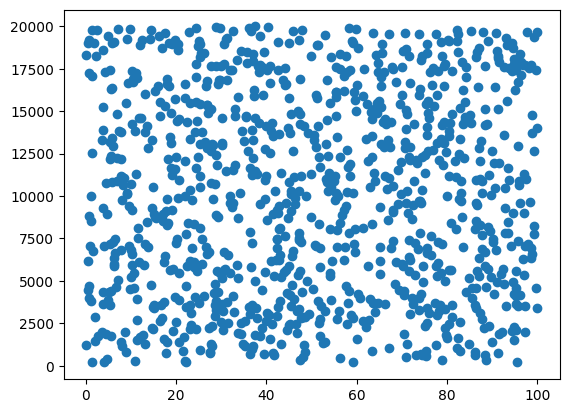

In [ ]:
# Постройте scatterplot
plt.scatter(
    x=df['feature'],
    y=df['cost']
)
plt.show()

Сразу можно сказать, что в этом случае линейная регрессия не будет работать совсем

In [ ]:
from sklearn.preprocessing import StandardScaler
# Отнормируйте значения в колонках датафрейма для удобства интерпретации коэффициентов регрессии, поделив их на максимальные значения
for col in df.columns:
  df[col] = df[col]/df[col].max()

In [ ]:
df.head(5)

,feature,cost
0,0.181953,0.608724
1,0.048646,0.971987
2,0.058769,0.541043
3,0.993314,0.389125
4,0.599786,0.993547


In [ ]:
# Постройте модель линейной регрессии из sklearn, обучите ее на всем датафрейме и выведите на экран коэффициенты
lin_reg = LinearRegression().fit(X=df['feature'].values.reshape(-1, 1), y=df['cost'])

In [ ]:
lin_reg.coef_

array([0.03033251])

In [ ]:
metrics_report(df['cost'], lin_reg.predict(df['feature'].values.reshape(-1, 1)))

R2 score: 0.000893426341328496
RMSE: 0.2904030773457971
MAPE: 1.639642186065602


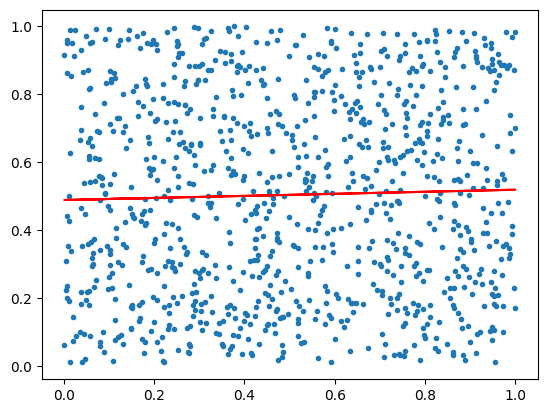

In [ ]:
# График предсказаний регрессии
plt.scatter(x=df['feature'], y=df['cost'], marker='.')
plt.plot(df['feature'], lin_reg.predict(df[['feature']]), color='r')
plt.show()

In [ ]:
# Теперь постройте регрессию из statsmodels. Но прежде чем это сделать, необходимо добавить в выборку константу с помощью функции sm.add_constant().
# Это необходимое техническое действие, без которого предсказания модели будут некорректными

X_sm = sm.add_constant(df['feature'])

In [ ]:
# Постройте и обучите модель. Выведите результаты обучения (summary). После этого заполните ответ в гугл-форме.

ols_model = OLS(df['cost'], X_sm)
ols_res = ols_model.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8924
Date:                Wed, 25 Sep 2024   Prob (F-statistic):              0.345
Time:                        13:36:01   Log-Likelihood:                -182.45
No. Observations:                1000   AIC:                             368.9
Df Residuals:                     998   BIC:                             378.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4885      0.019     26.345      0.0

In [ ]:
ols_res.rsquared

0.000893426341328496

#### Задание 2


Проверим предположение о необходимости репрезентативности выборки. Например, ограничим данные и сравним качество прогноза на полной и ограниченной выборках.

Пусть имеется набор данных о продажах домов. Рассмотрим две выборки, обучим на них модель линейной регрессии и сравним результаты. Первая выборка должна включать в себя только данные о домах, в которых не более 2 спальных комнат. Вторая выборка будет включать в себя все типы домов. Построить регрессию из statsmodels и в качестве ответа предоставить значения коэффициентов детерминации в обоих случаях (округлить до 3 знака)

Формат ответа: 0.333 0.342

In [ ]:
# Считайте данные из файла house_prices.csv и выведите первые 5 строк на экран
data = pd.read_csv('house_prices.csv', index_col=0)
data.head(5)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
price,,,,,,,,,,,,
13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
# Создайте списки категориальных и количественных переменных (целевую переменную в списки не включать)
var_categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
var_numeric = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

In [ ]:
# Закодируйте категориальные признаки (там, где значения 'yes'/'no', просто замените из на 1/0, остальное - с помощью OneHotEncoder())

data.replace({'yes': 1, 'no': 0}, inplace=True)
data.head(1)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
price,,,,,,,,,,,,
13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished


In [ ]:
# Сделайте две выборки, описанные в задании
X1 = data[data['bedrooms'] < 3]
X2 = data.copy()
y1 = X1.reset_index()['price']
y2 = X2.reset_index()['price']

In [ ]:
# Кодировка остальных категориальных признаков
encoder1 = OneHotEncoder(handle_unknown='ignore')

furnished_enc_1 = pd.DataFrame(
    encoder1.fit_transform(X1[['furnishingstatus']]).toarray(),
    columns=encoder1.categories_
)

encoder2 = OneHotEncoder(handle_unknown='ignore')

furnished_enc_2 = pd.DataFrame(
    encoder2.fit_transform(X2[['furnishingstatus']]).toarray(),
    columns=encoder2.categories_
)

In [ ]:
# Теперь масштабируйте количественные признаки
scaler1 = StandardScaler()

X1_numeric = pd.DataFrame(
    scaler1.fit_transform(X1[var_numeric]),
    columns=var_numeric
)

scaler2 = StandardScaler()

X2_numeric = pd.DataFrame(
    scaler2.fit_transform(X2[var_numeric]),
    columns=var_numeric
)

In [ ]:
columns = ['area','bedrooms','bathrooms',
           'stories','parking','mainroad',
           'guestroom','basement','hotwaterheating',
           'airconditioning','prefarea','furnished',
           'semi-furnished', 'unfurnished']

In [ ]:
# Соберите все в один датафрейм
X1_enc = X1_numeric.join([X1[var_categorical].reset_index(drop=True), furnished_enc_1]).drop('furnishingstatus', axis=1)

X1_enc.shape
X1_enc.columns = columns
X1_enc

,area,bedrooms,bathrooms,stories,parking,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnished,semi-furnished,unfurnished
0,2.215891,0.121268,-0.248069,-0.390279,0.719969,1,0,0,0,1,0,0.0,1.0,0.0
1,4.464476,0.121268,-0.248069,-0.390279,0.719969,1,0,1,1,0,0,1.0,0.0,0.0
2,1.029138,0.121268,4.031129,6.634747,-0.679407,1,0,1,0,0,1,1.0,0.0,0.0
3,1.107214,0.121268,-0.248069,-0.390279,2.119344,1,1,1,0,0,1,1.0,0.0,0.0
4,1.133239,0.121268,-0.248069,-0.390279,2.119344,1,1,1,0,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,-0.657301,0.121268,-0.248069,-0.390279,0.719969,1,0,0,0,0,0,0.0,0.0,1.0
134,-0.506875,0.121268,-0.248069,-0.390279,-0.679407,1,0,0,0,0,0,0.0,0.0,1.0
135,-0.849888,0.121268,-0.248069,-0.390279,0.719969,0,0,0,0,0,0,0.0,0.0,1.0
136,-0.844683,0.121268,-0.248069,-0.390279,2.119344,1,0,1,0,0,0,0.0,0.0,1.0


In [ ]:
X2_enc = X2_numeric.join([X2[var_categorical].reset_index(drop=True), furnished_enc_2]).drop('furnishingstatus', axis=1)
X2_enc.columns = columns

In [ ]:
# Для удобства переименуйте колонки, получившиеся при кодировании признака 'furnishingstatus' и удалите одну лишнюю ('unfurnished')
X1_enc.drop('unfurnished', axis=1)
X2_enc.drop('unfurnished', axis=1)

,area,bedrooms,bathrooms,stories,parking,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnished,semi-furnished
0,1.046726,1.403419,1.421812,1.378217,1.517692,1,0,0,0,1,1,1.0,0.0
1,1.757010,1.403419,5.405809,2.532024,2.679409,1,0,0,0,1,0,1.0,0.0
2,2.218232,0.047278,1.421812,0.224410,1.517692,1,0,1,0,0,1,0.0,1.0
3,1.083624,1.403419,1.421812,0.224410,2.679409,1,0,1,0,1,1,1.0,0.0
4,1.046726,1.403419,-0.570187,0.224410,1.517692,1,1,1,0,1,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,-0.991879,-1.308863,-0.570187,-0.929397,1.517692,1,0,1,0,0,0,0.0,0.0
541,-1.268613,0.047278,-0.570187,-0.929397,-0.805741,0,0,0,0,0,0,0.0,1.0
542,-0.705921,-1.308863,-0.570187,-0.929397,-0.805741,1,0,0,0,0,0,0.0,0.0
543,-1.033389,0.047278,-0.570187,-0.929397,-0.805741,0,0,0,0,0,0,1.0,0.0


In [ ]:
# К обеим выборкам добавьте константу для работы с моделями из statsmodels, затем выполните сброс индексов в обеих сериях целевой переменной

x1_sm = sm.add_constant(X1_enc)
x2_sm = sm.add_constant(X2_enc)

In [ ]:
# Постройте модели, обучите их на соответствующих выборках и выведите информацию о моделях
ols1 = OLS(y1, x1_sm)
ols1_res = ols1.fit()
print(ols1_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     17.69
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           1.83e-22
Time:                        12:22:44   Log-Likelihood:                -2030.0
No. Observations:                 138   AIC:                             4088.
Df Residuals:                     124   BIC:                             4129.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.468e+06   1.16e+05     

In [ ]:
ols2 = OLS(y2, x2_sm)
ols2_res = ols2.fit()
print(ols2_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          9.07e-123
Time:                        12:22:45   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.823e+06   1.03e+05     

In [ ]:
# Вызвав функцию metrics_report, определенную в начале ноутбука, выведите на экран значения метрик
# при предсказании обеих моделей на полном наборе данных (то есть на выборке с номером 2)
metrics_report(y2, ols1_res.predict(x2_sm))

R2 score: 0.2780547570913918
RMSE: 1587804.4707838513
MAPE: 0.1931528344587023


In [ ]:
metrics_report(y2, ols2_res.predict(x2_sm))

R2 score: 0.6818018485540142
RMSE: 1054128.892633344
MAPE: 0.1719315191565535


Вцелом неудивительный результат, что модель, обученная на более репрезентативной выборке, показала на тестовом датасете кратно лучший коэффициент детерминации.


#### Задание 3

Еще одно предположение, выполнение которого сильно влияет на результат работы линейной регрессии, - это предположение о строгой экзогенности. Суть заключается в следующем. Предположим, было составлено уравнение регрессии, в котором целевой признак `'y'` определяется признаком `'x'` и некоторой константой. Предположим также, что существует некоторый фактор `'t'`, который влияет и на `'x'`, и на `'y'`, однако в уравнении не присутствует. Это может быть какой-то невидимый нам, неявный фактор. Получается, что наше уравнение является неполным, не описывает картину в целом.

Пусть имеется набор данных из трех колонок: два признака (`'x'` и `'t'`) и таргет `'y'`. Необходимо (а) построить регрессию, используя только `'x'` и `'y'`; (б) построить регрессию на `'t'` и `'y'`. В качестве ответа выбрать верные значения коэффициентов детерминации

In [ ]:
# Создание нормально распределенного шума
rng = np.random.RandomState(RANDOM_STATE)
mu, sigma = 0, 0.1
eps = rng.normal(mu, sigma, size=1000)

In [ ]:
c_train = 0
c_test = 0.1

In [ ]:
# Создание набора данных
t = np.linspace(0, 1, 1000)

y = np.log(1 + t)
x = t + eps

df = pd.DataFrame({'t' : t, 'x' : x, 'y' : y})
df.head()

,t,x,y
0,0.000000,0.049671,0.000000
1,0.001001,-0.012825,0.001001
2,0.002002,0.066771,0.002000
3,0.003003,0.155306,0.002999
4,0.004004,-0.019411,0.003996


In [ ]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df[['x', 't']], df['y'], test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

X_train['x'] += c_train
X_test['x'] += c_test

In [ ]:
# Постройте модель только на 'x' и 'y', посчитайте коэффициент детерминации на тестовой выборке
model = OLS(y_train, sm.add_constant(X_train['x'])).fit()
metrics_report(y_test, model.predict(sm.add_constant(X_test['x'])))

R2 score: 0.7861747412879564
RMSE: 0.09160954420068763
MAPE: 1997194636440.5972


In [ ]:
# Постройте модель только на 't' и 'y', посчитайте коэффициент детерминации на тестовой выборке и сдайте ответ в гугл-форму
model = OLS(y_train, sm.add_constant(X_train['t'])).fit()
metrics_report(y_test, model.predict(sm.add_constant(X_test['t'])))

R2 score: 0.991879705210636
RMSE: 0.0178524208825073
MAPE: 508483230842.8887


In [ ]:
# Строю модель по всем признакам. Сугубо ради интереса
model = OLS(y_train, sm.add_constant(X_train)).fit()
metrics_report(y_test, model.predict(sm.add_constant(X_test)))

R2 score: 0.9918738332683288
RMSE: 0.017858874431557727
MAPE: 503395866877.5095


Отсюда можно сделать вывод о том, что для корректной работы модели важно правильно выбрать признаки.

#### Задание 4

Вернемся к данным о продаже домов. Постройте матрицу корреляций числовых признаков для тренировочной выборки. Закодируйте категориальные и масштабируйте количественные. После этого постройте регрессию из statsmodels и, проанализировав ее выдачу, определите признаки, не являющиеся полезными для построения модели. В качестве ответа на вопрос введите значение коэффициента корреляции Пирсона между признаками 'bedrooms' и 'stories', а также признаки, которые не являются полезными для модели и p-value для них (все выводится через пробел, десятичный разделитель - точка)

<u>Формат ответа:</u> corr_coef feature feature_p_value

<u>Пример:</u> 0.001 mainroad 0.123

In [ ]:
# Снова считайте данные из файла house_prices.csv
data = pd.read_csv('house_prices.csv', index_col=0)

In [ ]:
data.replace({'yes': 1, 'no': 0}, inplace=True)

In [ ]:
# Создайте списки категориальных и количественных переменных
var_categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
var_numeric = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

In [ ]:
# Разделите данные на тренировочную и тестовую выборки. ВАЖНО: здесь и везде далее, где это возможно, указывать параметр random_state=RANDOM_STATE.
# Размер тестовой выборки 0.4, перемешивание данных должно быть включено (параметр shuffle)
X, y = data.reset_index().drop('price', axis=1), data.reset_index()['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE, shuffle=True)
y_train.reset_index(drop=True, inplace=True), y_test.reset_index(drop=True, inplace=True)

(None, None)

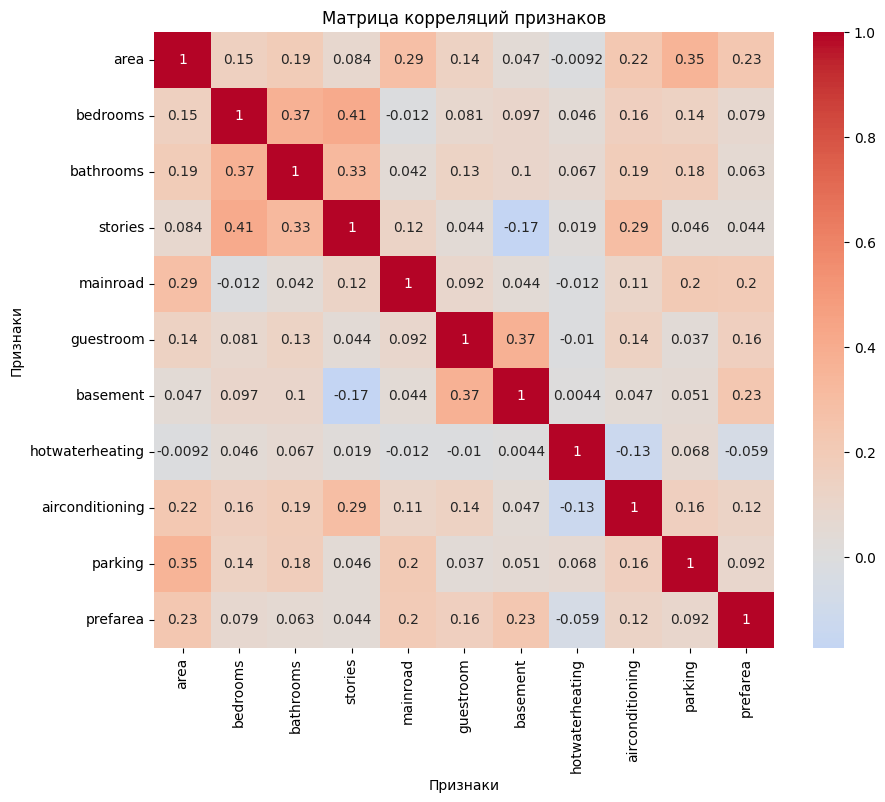

In [ ]:
# Построить матрицу корреляций
#corr_matrix = data[var_numeric].corr()
corr_matrix = data.drop('furnishingstatus', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

Линейной зависимости между признаками не наблюдается.
Максимум слабая корреляция

In [ ]:
# Выполните кодирование категориальных и масштабирование количественных признаков (аналогично заданию 2).
# После этого соберите все в один датафрейм, переименуйте и удалите нужные колонки и сбросьте индексы в сериях целевой переменной

train_scaler = StandardScaler()
test_scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    train_scaler.fit_transform(X_train[var_numeric]),
    columns = var_numeric)
X_test_scaled = pd.DataFrame(
    test_scaler.fit_transform(X_test[var_numeric]),
    columns=var_numeric)

train_encoder = OneHotEncoder(handle_unknown='ignore')
test_encoder = OneHotEncoder(handle_unknown='ignore')

X_train_furnished = pd.DataFrame(
    train_encoder.fit_transform(X_train[['furnishingstatus']]).toarray(),
    columns = train_encoder.categories_)
X_test_furnished = pd.DataFrame(
    test_encoder.fit_transform(X_test[['furnishingstatus']]).toarray(),
    columns = test_encoder.categories_)

X_train_scaled = X_train_scaled.join([X_train[var_categorical].reset_index(drop=True), X_train_furnished])
X_test_scaled = X_test_scaled.join([X_test[var_categorical].reset_index(drop=True), X_test_furnished])
X_train_scaled.columns = columns
X_test_scaled.columns = columns

X_train_scaled = X_train_scaled.drop('unfurnished', axis=1)
X_test_scaled = X_test_scaled.drop('unfurnished', axis=1)

In [ ]:
# Добавьте константы
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

In [ ]:
# Постройте модель линейной регрессии из statsmodels и, проанализировав ее выдачу,
# найдите признаки, не являющиеся важными для модели и сдайте ответ в гугл-форму.

model = OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     46.60
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           3.00e-65
Time:                        13:48:41   Log-Likelihood:                -4965.2
No. Observations:                 327   AIC:                             9958.
Df Residuals:                     313   BIC:                         1.001e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.466e+06   1.67e+05     

In [ ]:
from IPython import display

Будем сортировать признаки по важности на основе значений t-теста.

In [ ]:
# Удалите признаки, которые не являются важными, чтобы не учитывать их в дальнейших исследованиях
t_val = model.tvalues.sort_values()
df = pd.DataFrame(columns=['var', 'R-sq', 'Adj. R-sq', 'Likelihood', 'BIC'])

for i in range(0, len(t_val)):
  drop_columns = t_val[:i].index
  model = OLS(y_train, X_train_sm.drop(drop_columns, axis=1)).fit()
  df.loc[len(df)] = {'var': t_val[i:].index, 'R-sq': model.rsquared, 'Adj. R-sq': model.rsquared_adj, 'Likelihood': model.llf, 'BIC': model.bic}

In [ ]:
df

,var,R-sq,Adj. R-sq,Likelihood,BIC
0,"Index(['bedrooms', 'guestroom', 'mainroad', 's...",6.593597e-01,6.452117e-01,-4965.212417,10011.484276
1,"Index(['guestroom', 'mainroad', 'semi-furnishe...",6.577459e-01,6.446661e-01,-4965.985200,10007.239882
2,"Index(['mainroad', 'semi-furnished', 'hotwater...",6.531472e-01,6.410348e-01,-4968.167445,10005.814411
3,"Index(['semi-furnished', 'hotwaterheating', 'b...",6.479288e-01,6.367873e-01,-4970.608969,10004.907499
4,"Index(['hotwaterheating', 'basement', 'furnish...",6.394090e-01,6.291714e-01,-4974.518414,10006.936430
5,"Index(['basement', 'furnished', 'prefarea', 'p...",6.302446e-01,6.209426e-01,-4978.621825,10009.353291
6,"Index(['furnished', 'prefarea', 'parking', 'st...",6.043526e-01,5.956707e-01,-4989.687788,10025.695257
7,"Index(['prefarea', 'parking', 'stories', 'airc...",5.943227e-01,5.867162e-01,-4993.780945,10028.091611
8,"Index(['parking', 'stories', 'airconditioning'...",5.659596e-01,5.591988e-01,-5004.830202,10044.400166
9,"Index(['stories', 'airconditioning', 'bathroom...",5.415482e-01,5.358532e-01,-5013.776502,10056.502804


Возьмем только те переменные, на которых Байесовский информационный критерий минимален, а коэффициент детерминации ещё не сильно упал

In [ ]:
df

,var,R-sq,Adj. R-sq,Likelihood,BIC
0,"Index(['bedrooms', 'guestroom', 'mainroad', 's...",6.593597e-01,6.452117e-01,-4965.212417,10011.484276
1,"Index(['guestroom', 'mainroad', 'semi-furnishe...",6.577459e-01,6.446661e-01,-4965.985200,10007.239882
2,"Index(['mainroad', 'semi-furnished', 'hotwater...",6.531472e-01,6.410348e-01,-4968.167445,10005.814411
3,"Index(['semi-furnished', 'hotwaterheating', 'b...",6.479288e-01,6.367873e-01,-4970.608969,10004.907499
4,"Index(['hotwaterheating', 'basement', 'furnish...",6.394090e-01,6.291714e-01,-4974.518414,10006.936430
5,"Index(['basement', 'furnished', 'prefarea', 'p...",6.302446e-01,6.209426e-01,-4978.621825,10009.353291
6,"Index(['furnished', 'prefarea', 'parking', 'st...",6.043526e-01,5.956707e-01,-4989.687788,10025.695257
7,"Index(['prefarea', 'parking', 'stories', 'airc...",5.943227e-01,5.867162e-01,-4993.780945,10028.091611
8,"Index(['parking', 'stories', 'airconditioning'...",5.659596e-01,5.591988e-01,-5004.830202,10044.400166
9,"Index(['stories', 'airconditioning', 'bathroom...",5.415482e-01,5.358532e-01,-5013.776502,10056.502804


In [ ]:
choosed_columns = df.loc[3]['var'].values[df.loc[3]['var'].values != 'const']

X_train_scaled = X_train_scaled[choosed_columns]
X_test_scaled = X_test_scaled[choosed_columns]

#### Задание 5

Проверьте важность признаков. Для этого постройте регрессию только на площади квартиры и выберите в гугл-форме все верные ответы.

In [ ]:
# Постройте регрессию из statsmodels только на площади (не забудьте добавить константы)
X_sm = sm.add_constant(X_train_scaled['area'])

In [ ]:
# Теперь постройте регрессию на всех признаках
model = OLS(y_train, X_sm).fit()

In [ ]:
# Анализируя выдачу statsmodels, выберите все верные ответы
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     128.8
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           2.31e-25
Time:                        12:23:26   Log-Likelihood:                -5086.7
No. Observations:                 327   AIC:                         1.018e+04
Df Residuals:                     325   BIC:                         1.019e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.598e+06   7.65e+04     60.115      0.0

#### Задание 6

Каково примерное изменение стоимости дома при увеличении количества этажей на два (разумеется, при прочих равных)? Проверить, построив линейную регрессию. В качестве ответа выбрать значение, максимально близкое к полученному Вами теоретически, и значение, максимально совпадающее с полученным путем построения линейной регрессии (при самостоятельном расчете взять разность средних значений)

In [ ]:
# В этом задании признак 'bedrooms' оставьте
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [ ]:
# Создайте датафрейм, в котором количество этажей в каждом доме будет больше на два
df = data.copy()
df.stories += 2

In [ ]:
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,5,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,6,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,4,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,4,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,4,1,1,1,0,1,2,0,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,3,1,0,1,0,0,2,0,unfurnished
541,1767150,2400,3,1,3,0,0,0,0,0,0,0,semi-furnished
542,1750000,3620,2,1,3,1,0,0,0,0,0,0,unfurnished
543,1750000,2910,3,1,3,0,0,0,0,0,0,0,furnished


In [ ]:
# Закодируйте категориальные и масштабируйте количественные признаки в обоих датафреймах
original_X, original_y = data.reset_index(drop=True), data.index
changed_X, changed_y = df.reset_index(drop=True), df.index

original_scaler = StandardScaler()
changed_scaler = StandardScaler()

original_X_scaled = pd.DataFrame(
    original_scaler.fit_transform(original_X[var_numeric]),
    columns = var_numeric
)
changed_X_scaled = pd.DataFrame(
    changed_scaler.fit_transform(changed_X[var_numeric]),
    columns = var_numeric
)

original_OHE = OneHotEncoder(handle_unknown='ignore')
changed_OHE = OneHotEncoder(handle_unknown='ignore')

original_X_furnished = pd.DataFrame(
    original_OHE.fit_transform(original_X[['furnishingstatus']]).toarray(),
    columns = original_OHE.categories_
)
changed_X_furnished = pd.DataFrame(
    changed_OHE.fit_transform(changed_X[['furnishingstatus']]).toarray(),
    columns = changed_OHE.categories_
)

original_X_scaled = original_X_scaled.join([original_X[var_categorical], original_X_furnished])
changed_X_scaled = changed_X_scaled.join([changed_X[var_categorical], changed_X_furnished])

original_X_scaled = original_X[var_numeric].join([original_X[var_categorical], original_X_furnished])
changed_X_scaled = changed_X[var_numeric].join([changed_X[var_categorical], changed_X_furnished])

columns = ['area','bedrooms','bathrooms',
           'stories','parking','mainroad',
           'guestroom','basement','hotwaterheating',
           'airconditioning','prefarea','furnished',
           'semi-furnished', 'unfurnished']

original_X_scaled.columns = columns
changed_X_scaled.columns = columns

original_X_scaled.drop('unfurnished', axis=1, inplace=True)
changed_X_scaled.drop('unfurnished', axis=1, inplace=True)

In [ ]:
# Не забудьте добавить константы и постройте модель регрессии из statsmodels, обучите ее на исходном наборе (data_sm)

data_sm = sm.add_constant(original_X_scaled)
df_sm = sm.add_constant(changed_X_scaled)

ols_model = OLS(original_y, data_sm).fit()

In [ ]:
# Выполните предсказания на обоих наборах данных (data_sm и df_sm) и вычислите разность средних значений этих предсказаний. Сдайте ответ в гугл-форму

ols_model.predict(df_sm).mean() - ols_model.predict(data_sm).mean()



639536.7254600525

In [ ]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     95.51
Date:                Wed, 25 Sep 2024   Prob (F-statistic):          1.15e-129
Time:                        13:42:01   Log-Likelihood:                -3201.6
No. Observations:                 545   AIC:                             6431.
Df Residuals:                     531   BIC:                             6491.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             416.0743     11.913     

#### Задание 7

Теперь займемся проверкой допущений. Для начала проверим отсутствие мультиколлинеарности. Это можно сделать с помощью VIF (Variance Inflation Factor). Если он будет больше 4 (договорное значение, аналогичное p-value), то эта переменная коррелирует с какой-то из присутствующих, и ее нужно убрать.

Рассчитайте VIF для всех колонок и найдите те, которые коррелируют. После этого постройте две регрессии: с одним из коррелирующих признаков и с обоими (все остальные признаки тоже включаем, конечно). Выберите все верные ответы из списка.

In [ ]:
# Снова считайте набор данных house_prices.csv, разделите его на тренировочную и тестовую выборки,
# закодируйте категориальные и масштабируйте количественнные признаки

data = pd.read_csv('house_prices.csv')
data = data.replace({'yes': 1, 'no': 0})

In [ ]:
# random_state=RANDOM_STATE, перемешивание включено, размер тестовой выборки 0.4
X, y = data.drop('price', axis=1), data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=RANDOM_STATE)
X_train.reset_index(drop=True, inplace=True), X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True), y_test.reset_index(drop=True, inplace=True)

(None, None)

In [ ]:
train_scaler = StandardScaler()
test_scaler = StandardScaler()

train_X_scaled = pd.DataFrame(
    train_scaler.fit_transform(X_train[var_numeric]),
    columns = var_numeric
)
test_X_scaled = pd.DataFrame(
    test_scaler.fit_transform(X_test[var_numeric]),
    columns = var_numeric
)

train_X_scaled

,area,bedrooms,bathrooms,stories,parking
0,-0.073972,-1.248938,-0.511306,0.279359,-0.777426
1,0.704644,0.081364,-0.511306,-0.922620,-0.777426
2,-1.402054,0.081364,-0.511306,1.481337,-0.777426
3,0.891906,-1.248938,-0.511306,-0.922620,1.643701
4,-0.877228,0.081364,-0.511306,0.279359,-0.777426
...,...,...,...,...,...
322,0.497670,1.411666,1.717987,2.683316,-0.777426
323,0.226633,1.411666,1.717987,-0.922620,-0.777426
324,-0.241522,0.081364,1.717987,1.481337,0.433137
325,-0.468208,-1.248938,-0.511306,-0.922620,-0.777426


In [ ]:
train_OHE = OneHotEncoder(handle_unknown='ignore')
test_OHE = OneHotEncoder(handle_unknown='ignore')

train_X_furnished = pd.DataFrame(
    train_OHE.fit_transform(X_train[['furnishingstatus']]).toarray(),
    columns = train_OHE.categories_
)
test_X_furnished = pd.DataFrame(
    test_OHE.fit_transform(X_test[['furnishingstatus']]).toarray(),
    columns = test_OHE.categories_
)

train_X_furnished

,furnished,semi-furnished,unfurnished
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
322,0.0,0.0,1.0
323,0.0,1.0,0.0
324,1.0,0.0,0.0
325,0.0,0.0,1.0


In [ ]:
train_X_scaled = train_X_scaled.join([X_train[var_categorical], train_X_furnished])
test_X_scaled = test_X_scaled.join([X_test[var_categorical], test_X_furnished])

train_X_scaled

,area,bedrooms,bathrooms,stories,parking,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,"(furnished,)","(semi-furnished,)","(unfurnished,)"
0,-0.073972,-1.248938,-0.511306,0.279359,-0.777426,1,0,0,0,0,0,0.0,0.0,1.0
1,0.704644,0.081364,-0.511306,-0.922620,-0.777426,1,0,1,0,1,1,1.0,0.0,0.0
2,-1.402054,0.081364,-0.511306,1.481337,-0.777426,1,0,0,0,0,1,1.0,0.0,0.0
3,0.891906,-1.248938,-0.511306,-0.922620,1.643701,1,1,1,0,0,0,1.0,0.0,0.0
4,-0.877228,0.081364,-0.511306,0.279359,-0.777426,1,0,1,0,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.497670,1.411666,1.717987,2.683316,-0.777426,1,0,0,0,1,0,0.0,0.0,1.0
323,0.226633,1.411666,1.717987,-0.922620,-0.777426,1,0,1,0,1,1,0.0,1.0,0.0
324,-0.241522,0.081364,1.717987,1.481337,0.433137,1,0,0,1,0,0,1.0,0.0,0.0
325,-0.468208,-1.248938,-0.511306,-0.922620,-0.777426,1,0,0,0,0,0,0.0,0.0,1.0


In [ ]:
columns = ['area','bedrooms','bathrooms',
           'stories','parking','mainroad',
           'guestroom','basement','hotwaterheating',
           'airconditioning','prefarea','furnished',
           'semi-furnished', 'unfurnished']

train_X_scaled.columns = columns
test_X_scaled.columns = columns

train_X_scaled.drop('unfurnished', axis=1, inplace=True)
test_X_scaled.drop('unfurnished', axis=1, inplace=True)

In [ ]:
# Вычислите VIF и найдите коррелирующие признаки
vif_data = pd.DataFrame()
vif_data["feature"] = train_X_scaled.columns

vif_data["VIF"] = [variance_inflation_factor(train_X_scaled.values, i) for i in range(train_X_scaled.shape[1])]
vif_data

,feature,VIF
0,area,1.240984
1,bedrooms,1.385571
2,bathrooms,1.247899
3,stories,1.529252
4,parking,1.162064
5,mainroad,3.403351
6,guestroom,1.570489
7,basement,2.098776
8,hotwaterheating,1.118430
9,airconditioning,1.820774


Самое высокое значение VIF у признака mainroad

In [ ]:
# Постройте регрессию из statsmodels, обучите ее на выборке без одного из коррелирующих признаков.
# Проделайте то же самое на выборке со всеми признаками.

X_sm = sm.add_constant(train_X_scaled).drop('mainroad', axis=1)
model_1 = OLS(y_train, X_sm).fit()
print(model_1.summary())

X_sm = sm.add_constant(train_X_scaled)
model_2 = OLS(y_train, X_sm).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     49.34
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           5.85e-65
Time:                        12:25:44   Log-Likelihood:                -4968.0
No. Observations:                 327   AIC:                             9962.
Df Residuals:                     314   BIC:                         1.001e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             3.76e+06    1.1e+05     

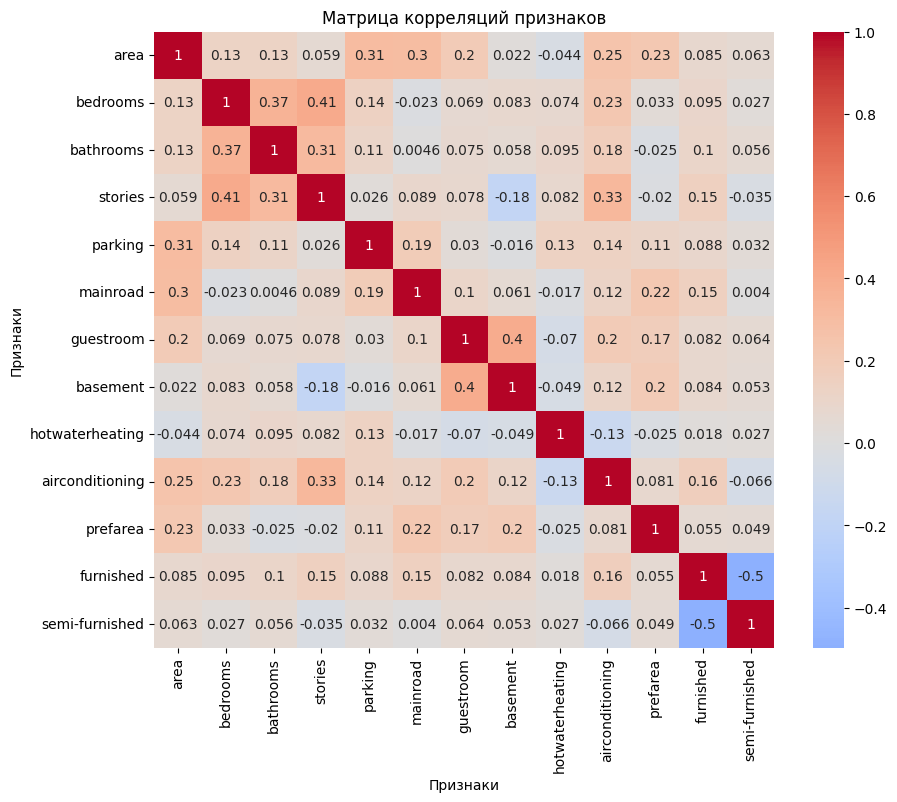

In [ ]:
corr_matrix = train_X_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

#### Задание 8

С помощью теста Уайта проверить отсутствие гетероскедастичности, то есть равенство дисперсий ошибок всех признаков. В качестве ответа сдать p-value этого теста.

О тесте Уайта. В качестве нулевой гипотезы примем равенство дисперсий ошибок всех признаков. Альтернатива, соответственно, будет за нарушение этого равенства. Если мы будем вынуждены отвергнуть нулевую гипотезу ($p-value < 0.05$), то можно будет сделать вывод о присутствии гетероскедастичности в наших данных.

Суть теста в следующем. Часто гетероскедастичность модели вызвана зависимостью (возможно, довольно сложной) дисперсий ошибок от признаков. На основе этого факта можно провести тест без каких-либо предположений о структуре гетероскедастичности. Сначала к исходной модели применяется обычный метод наименьших квадратов и находятся остатки регрессии $e_t$. Затем осуществляется регрессия квадратов этих остатков $e_t^2$ на все признаки, их квадраты, попарные произведения и константу. Тогда при гипотезе $H_0$ величина $NR^2$ асимптотически имеет распределение $\chi^2(N-1)$, где $R^2$ — коэффициент детерминации, а $N$ — число регрессоров второй регрессии. Плюс данного теста — его универсальность. Минусы : 1) если гипотеза $H_0$ отвергается, то никаких указаний на функциональную форму гетероскедастичности мы не получаем; 2) поиск вида регрессии вслепую (начинаем приближать простыми полиномами второй степени без какой бы то ни было причины на это)

In [ ]:
# Для проведения теста Уайта постройте линейную регрессию, предварительно удалив признаки 'bedrooms' и 'special_index'
X_sm = sm.add_constant(train_X_scaled)
ols_model = OLS(y_train, X_sm.drop(['bedrooms'], axis=1))
ols_res = ols_model.fit()

In [ ]:
ols_res.resid.shape[0]

327

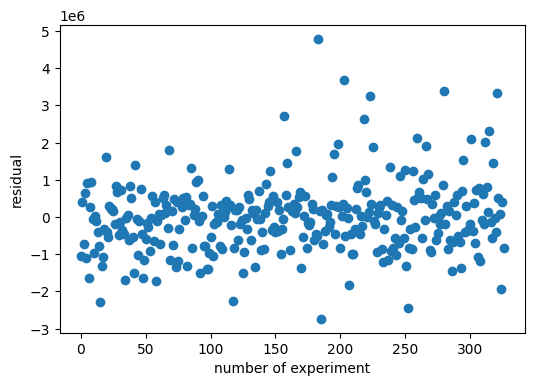

In [ ]:
# Постройте график остатков от номера эксперимента
plt.figure(figsize=(6, 4))
plt.xlabel('number of experiment')
plt.ylabel('residual')
plt.scatter(x=list(range(ols_res.resid.shape[0])), y=ols_res.resid)
plt.show()

In [ ]:
# Проведите тест Уайта
white_test = het_white(
    ols_res.resid,
    ols_res.model.exog
)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

print(dict(zip(labels, white_test)))

{'Test Statistic': 144.5111656128216, 'Test Statistic p-value': 1.3480696353117851e-05, 'F-Statistic': 2.4350631409953696, 'F-Test p-value': 8.341578725445199e-08}


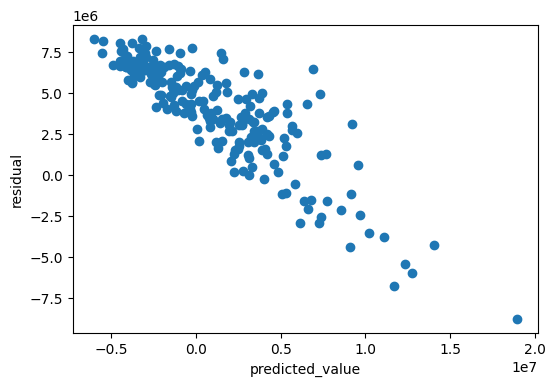

In [ ]:
# Постройте график остатков регрессии от предсказанных значений
plt.figure(figsize=(6, 4))
plt.xlabel('predicted_value')
plt.ylabel('residual')
plt.scatter(x=ols_res.predict(test_X_scaled), y=list(y_test - ols_res.predict(test_X_scaled)))
plt.show()

#### Задание 9

Имеется набор данных о заболевании сахарным диабетом. В качестве признаков выступают пол, ИМТ и другие. Целевая переменная - некоторый медицинский показатель, связанный со степенью диабета. Проверить наличие мультиколлинеарности в данных. Построить обычную регрессию и посмотреть на ее коэффициенты при коррелирующих признаках. Затем построить регрессию с L1-регуляризацией (LASSO) и убедиться, что коэффициенты при коррелирующих признаках стремятся к нулю. В качестве ответа выберите признаки, при которых модель LASSO-регрессии занулила коэффициенты.

In [ ]:
# Загрузите набор данных
from sklearn import datasets

diabetes = datasets.load_diabetes()

df = pd.DataFrame(diabetes.data)
df.columns = diabetes.feature_names

df['diabetes_measure'] = diabetes.target
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,diabetes_measure
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [ ]:
# Нормируйте целевой признак на максимальное значение и разбейте данные на тренировочную и тестовую выборки.
# Размер тестовой выборки 0.25, перемешивание включено, random_state=RANDOM_STATE
X, y = df.drop('diabetes_measure', axis=1), df['diabetes_measure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=RANDOM_STATE, shuffle=True)

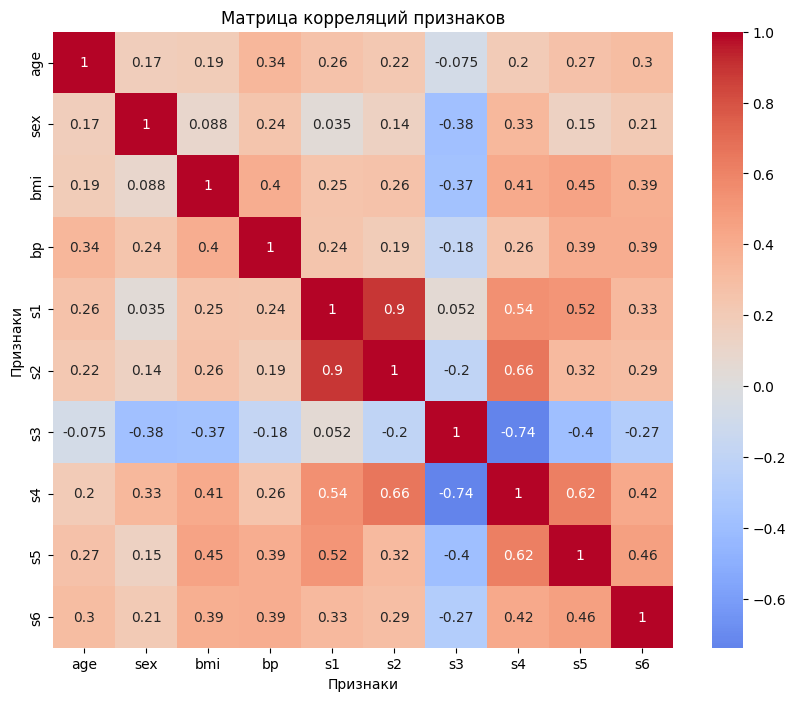

In [ ]:
# Постройте матрицу корреляций
corr_matrix = df.drop('diabetes_measure', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [ ]:
# Построить регрессию из sklearn, обучить ее и рассчитать метрику RMSE, используя функцию cross_val_score
lin_reg = LinearRegression().fit(X_train, y_train)

rmse = cross_val_score(
    estimator=lin_reg,
    X=X_train,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=10
)

-rmse.mean()

55.67650039089133

In [ ]:
# Выполнить предсказания и вывести метрики с помощью функции metrics_report
metrics_report(y_test, lin_reg.predict(X_test))

R2 score: 0.4849058889476756
RMSE: 53.369566710321955
MAPE: 0.37310970433744683


In [ ]:
# Вывести отсортированные коэффициенты регрессии
coefs = []
for i in range(len(X_train.columns)):
    col = X_train.columns[i]
    coef = lin_reg.coef_[i]
    coefs.append((col, coef))

coefs.sort(key=lambda x: x[1], reverse=True)
for i in range(len(coefs)):
    print(f'{coefs[i][0]} : {coefs[i][1] : .2f}')

s5 :  695.81
bmi :  531.97
s2 :  508.26
bp :  381.56
s4 :  269.49
s3 :  116.95
age :  47.75
s6 :  26.32
sex : -241.99
s1 : -918.50


In [ ]:
# Построить регрессию с L1-регуляризацией, осуществить автоматический поиск оптимальных гиперпараметров с помощью GridSearchCV.
# Обучить регрессию с оптимальными параметрами и, выведя ее коэффициенты, выяснить, какие признаки модель занулила
lasso = Lasso()

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}

clf = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=5)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0,
                                   10.0]},
             scoring='neg_root_mean_squared_error')

In [ ]:
clf.best_params_

{'alpha': 0.001}

In [ ]:
lasso = Lasso(alpha=10.0).fit(X_train, y_train)
lasso.coef_

array([ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.])

In [ ]:
# Аналогично случаю обычной регрессии выведите коэффициенты модели для всех признаков, чтобы найти те, которые модель занулила
# Сдайте ответ в гугл-форме
lasso.coef_

array([  47.68340057, -241.09526717,  532.95244807,  380.72044949,
       -854.08849854,  459.59052496,   86.08282907,  257.00194078,
        672.33280623,   26.54160078])

In [ ]:
for alpha in params['alpha']:
  print(alpha)
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)
  metrics_report(y_test, lasso.predict(X_test))

0.001
R2 score: 0.4853215083060125
RMSE: 53.34803093575148
MAPE: 0.37281616942162843
0.01
R2 score: 0.4880363435126295
RMSE: 53.207144333978974
MAPE: 0.37089272623591996
0.05
R2 score: 0.49686797802577154
RMSE: 52.74622269803512
MAPE: 0.3707813765744999
0.1
R2 score: 0.5019753487835406
RMSE: 52.4778222960648
MAPE: 0.37150756606276103
0.5
R2 score: 0.4765201870859217
RMSE: 53.80223955264992
MAPE: 0.4061341309835775
1.0
R2 score: 0.3791413953419158
RMSE: 58.59313519619829
MAPE: 0.4750821778741255
5.0
R2 score: -0.014016723490579253
RMSE: 74.88122548938378
MAPE: 0.6431454682309884
10.0
R2 score: -0.014016723490579253
RMSE: 74.88122548938378
MAPE: 0.6431454682309884


In [ ]:
lasso = Lasso(alpha=1.0).fit(X_train, y_train)
df = pd.DataFrame({'coef': lasso.coef_, 'name': X_train.columns})
df[df['name'] == 's3'].coef.values[0]

-0.0

#### Задание 10

Рассмотрим все тот же набор данных о заболевании диабетом. Только теперь добавился еще один признак 's7'. Построить регрессию, затем применить регуляризацию и в качестве ответа сдать соответствующие коэффициенты детерминации, рассчитанные на тестовой выборке. Ответ округлить до третьего знака.

<u>Формат ответа:</u> lin_reg_r2 ridge_r2 lasso_r2

In [ ]:
X_train['s7'] = np.sin(X_train['s3']) + X_train['s3'] ** 2 + X_train['s3']
X_test['s7'] = np.sin(X_test['s3']) + X_test['s3'] ** 2 + X_test['s3']

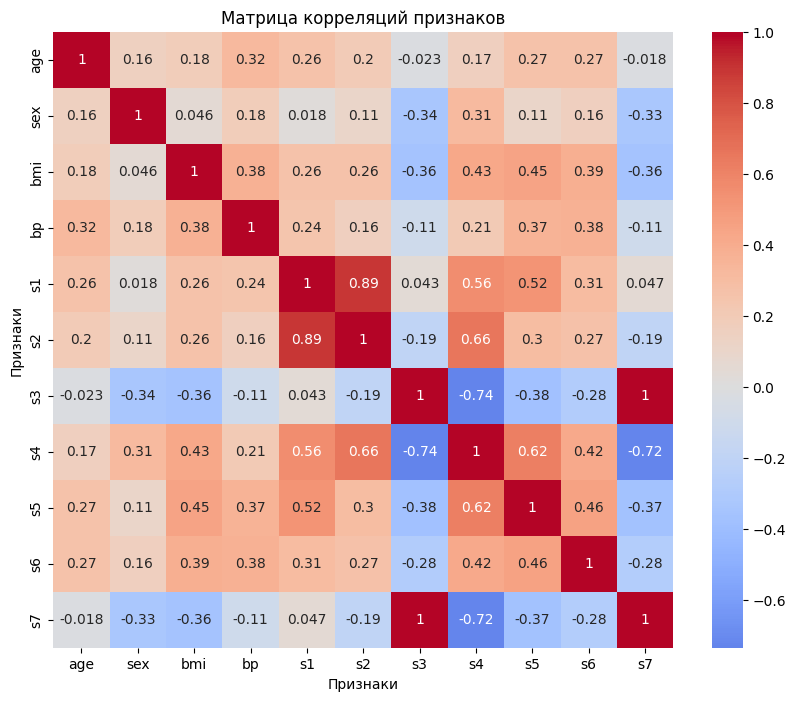

In [ ]:
# Постройте матрицу корреляций
corr_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [ ]:
# Постройте линейную регрессию из sklearn и оцените качество модели с помощью кросс-валидации, как в задании выше
lin_reg = LinearRegression().fit(X_train, y_train)

metrics_report(y_test, lin_reg.predict(X_test))

R2 score: 0.46928407246725135
RMSE: 54.17282021516018
MAPE: 0.38155454545124


In [ ]:
# Выполните предсказания на тренировочной и на тестовой выборках и по значениям коэффициента детерминации убедитесь в присутствии переобучения
metrics_report(y_train, lin_reg.predict(X_train))

R2 score: 0.5209507347143026
RMSE: 53.811457568856376
MAPE: 0.3898110259226531


In [ ]:
# Постройте регрессию с L2-регуляризацией, выполните предсказания на тренировочной и тестовой выборках (не забывайте про random_state)
ridge = Ridge()

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
          'solver' : ['saga', 'svd', 'lsqr']}

clf = GridSearchCV(ridge, params, scoring='neg_root_mean_squared_error', cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'alpha': 0.001, 'solver': 'svd'}


In [ ]:
best_score = 0
best_params = ''
params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
          'solver' : ['saga', 'svd', 'lsqr']}

for solver in params['solver']:
  for alpha in params['alpha']:
    ridge = Ridge(alpha=alpha, solver=solver).fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
  #  metrics_report(y_test, y_pred)
    if best_score < r2_score(y_test, y_pred):
      best_score = r2_score(y_test, y_pred)
      best_params = f'{solver} and {alpha}'

print(best_params)

svd and 0.1


In [ ]:
# Обучите регрессию с оптимальными параметрами и выполните предсказания
lin_reg = Ridge(alpha=0.1, solver='svd').fit(X_train, y_train)
metrics_report(y_test, lin_reg.predict(X_test))

R2 score: 0.491827073685539
RMSE: 53.009797643578295
MAPE: 0.3733036396885584


In [ ]:
# Аналогично с LASSO-регрессией
lasso = Lasso()
params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}

clf = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=100)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'alpha': 0.001}


In [ ]:
best_score = 0
best_params = ''
params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}

for alpha in params['alpha']:
  lasso = Lasso(alpha=alpha).fit(X_train, y_train)
  y_pred = lasso.predict(X_test)
#  metrics_report(y_test, y_pred)
  if best_score < r2_score(y_test, y_pred):
    best_score = r2_score(y_test, y_pred)
    best_params = f'{alpha}'

print(best_params)

0.1


In [ ]:
lin_reg = Lasso(alpha=0.1).fit(X_train, y_train)
metrics_report(y_test, lin_reg.predict(X_test))

R2 score: 0.5019753487835406
RMSE: 52.4778222960648
MAPE: 0.37150756606276103
